<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Model and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics


# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# spicy
from scipy.stats import skew
from scipy.stats import boxcox
from scipy.stats import yeojohnson

import warnings
warnings.filterwarnings('ignore')

In [2]:
from platform import python_version
print('Python version:', python_version())

Python version: 3.9.6


In [3]:
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

matplotlib : 3.4.2
statsmodels: 0.12.2
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
numpy      : 1.21.1
pandas     : 1.3.0
seaborn    : 0.11.1
sklearn    : 0.24.2



In [4]:
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
hourly_rentals.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain_type,count
0,2021-03-01,2,0.0,-1.2,98,4,1,3,2021,False,0,Monday,True,Winter,False,Night,no rain,1
1,2021-03-01,7,0.0,2.1,100,4,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,3
2,2021-03-01,8,0.0,5.1,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,1
3,2021-03-01,9,0.0,5.7,98,5,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,4
4,2021-03-01,10,0.0,6.7,94,6,1,3,2021,False,0,Monday,True,Winter,True,Morning,no rain,4


In [5]:
df = hourly_rentals.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category',
                'hour': 'category',
                'season': 'category',
                'peak': 'category',
                'timesofday': 'category'})
# predictors = ['temp','wdsp','rhum','rain_type','holiday','season','peak','timesofday']
predictors = ['temp','wdsp','rhum','rain']

# OrdinalEnconder was chosen due 
enc = OrdinalEncoder(dtype=np.int64, categories=[['no rain', 'drizzle', 'light rain', 'moderate rain', 'heavy rain']])
df['rain_type'] = enc.fit_transform(df[['rain_type']])

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')

# X['rain_type'] = pd.to_numeric(X['rain_type'])

num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

# dummies = pd.get_dummies(X[cat_vars], drop_first=True)
# X = pd.concat([X[num_vars], dummies],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((4876, 4), (2090, 4))

## Linear Regression Assumptions

In [7]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     272.3
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          1.69e-211
Time:                        21:55:08   Log-Likelihood:                -12373.
No. Observations:                4876   AIC:                         2.476e+04
Df Residuals:                    4871   BIC:                         2.479e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5679      0.477     24.264      0.0

In [8]:
predicted_values = model.predict()
lin_residuals = model.resid

### 1 - Linearity

This assumes that there is a linear relationship between the predictors and the response variable.

If this assumption is not met there are few ways to attempt fixing it: either adding polynomial terms to some of the predictors or applying nonlinear transformations . If those do not work, try adding additional variables to help capture the relationship between the predictors and the label.


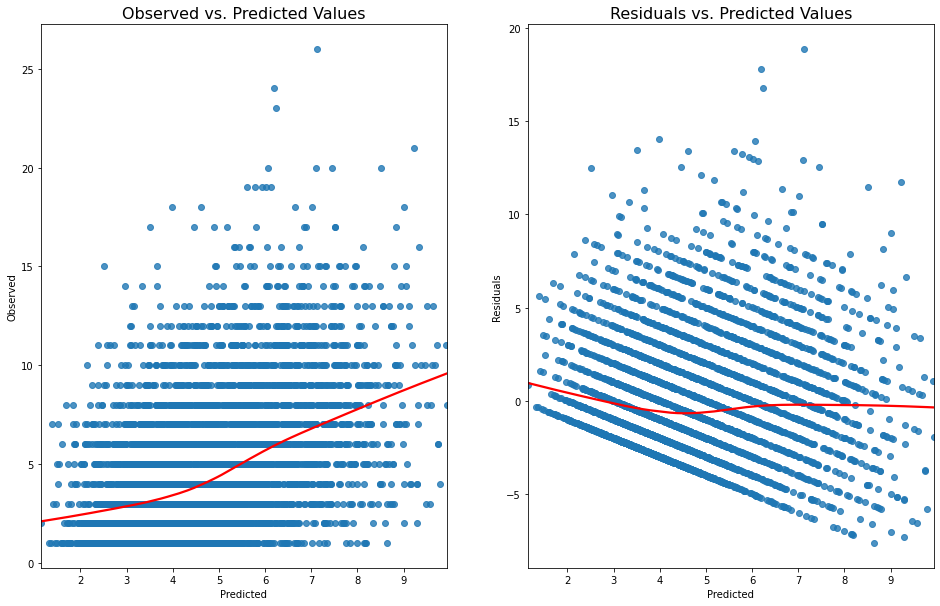

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16, 10))
    
sns.regplot(x=predicted_values, y=y_train, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=predicted_values, y=lin_residuals, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals');

In [33]:
from sklearn.preprocessing import PowerTransformer
p = PowerTransformer(method = 'yeo-johnson')
y_train_tranformed = p.fit_transform(y_train.to_frame())

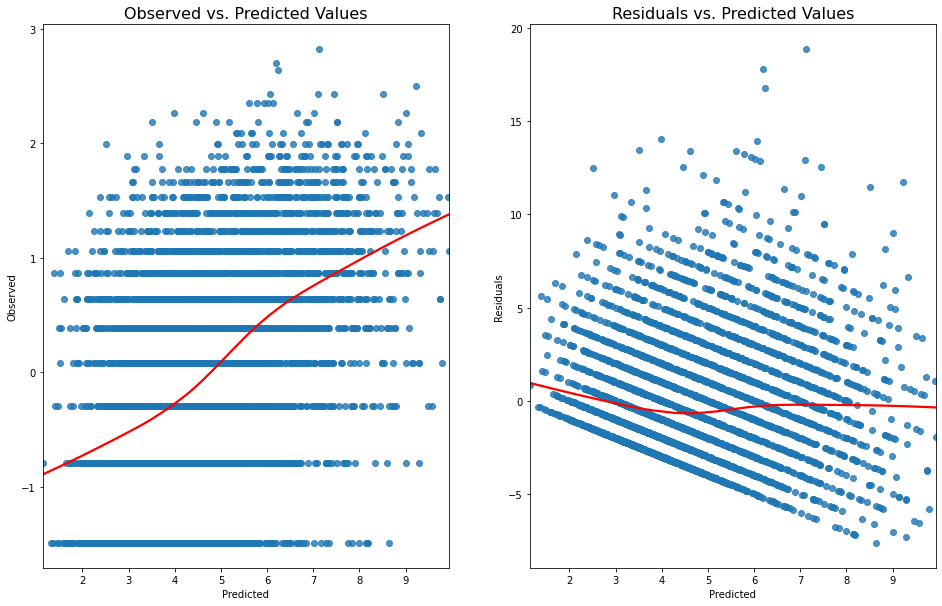

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16, 10))
    
sns.regplot(x=predicted_values, y=y_train_tranformed, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=predicted_values, y=lin_residuals, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals');

In [ ]:
vif = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

In [ ]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_train)
X_poly_constant = sm.add_constant(X_poly)
lin2 = sm.OLS(y_train, X_poly_constant).fit()
linearity_test(lin2, y_train) 

In [ ]:
transformed_target, lam = boxcox(y_train)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(y_train, label= 'Orginal Skew :{0}'.format(np.round(skew(y_train),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(transformed_target, label= 'Transformed Skew:{0}'.format(np.round(skew(transformed_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
transformed_target, lam = yeojohnson(y_train)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(y_train, label= 'Orginal Skew :{0}'.format(np.round(skew(y_train),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(transformed_target, label= 'Transformed Skew:{0}'.format(np.round(skew(transformed_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

In [ ]:
linearity_test(model, transformed_target)

In [ ]:
corrMatt = hourly_rentals[['temp','wdsp','rhum', 'rain','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(180, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

In [ ]:
hourly_data_temp = X_train.copy()
# hourly_data_temp['temp_type'] =  np.where(hourly_data_temp['temp'] > 10, 'High', 'Low')
# hourly_data_temp['prodTempWind'] = hourly_data_temp['temp']*hourly_data_temp['wdsp']
hourly_data_temp['prodRainWind'] = hourly_data_temp['rain']+hourly_data_temp['wdsp']

In [ ]:
hourly_data_temp.head(2)

In [ ]:
hourly_data_temp.drop(columns=['rain', 'wdsp'], inplace=True)
hourly_data_temp.head(2)

In [ ]:
X_with_constant = sm.add_constant(hourly_data_temp)
model = sm.OLS(y_train, X_with_constant).fit()
print(model.summary())

In [ ]:
linearity_test(model, y_train)

In [ ]:
X_with_constant.head()

In [ ]:
vif = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=hourly_data_temp.columns).T


### Wind Speed Beaufort scale

https://www.metoffice.gov.uk/weather/guides/coast-and-sea/beaufort-scale

In [ ]:
import math
def scale(value, factor):
    """
    Multiply value by factor, allowing for None values.
    """
    return None if value is None else value * factor

def wind_ms(kn):
    """
    Convert wind from knots to metres per second
    """
    return scale(kn, 0.514)

def wind_kn(ms):
    """
    Convert wind from metres per second to knots
    """
    return scale(ms, 3.6 / 1.852)

def wind_bft(ms):
    """
    Convert wind from metres per second to Beaufort scale
    """
    _bft_threshold = (0.3, 1.5, 3.4, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4, 28.4, 32.6)
    if ms is None:
        return None
    return next((bft for bft in range(len(_bft_threshold)) if ms < _bft_threshold[bft]), len(_bft_threshold))

In [ ]:
hourly_data_temp['wind_bft'] = hourly_data_temp.apply(lambda row: wind_bft(wind_ms(row.wdsp)), axis=1)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=hourly_data_temp, x='wind_bft', y='count', ci=None)
ax.set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')
plt.show()

# Transformations

## Log Transformation

In [ ]:
log_target = np.log1p(hourly_rentals['count'])
# log_target = np.log1p(hourly_data['count'].sample(frac=0.2, replace=False))
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew:{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(log_target, label= 'Transformed Skew:{0}'.format(np.round(skew(log_target),4)), color='g', ax=ax[1], axlabel='LOG TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Square Root Transformation

In [ ]:
sqrrt_target = hourly_rentals['count']**(1/2)
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew:{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(sqrrt_target, label= 'Transformed Skew:{0}'.format(np.round(skew(sqrrt_target),4)), color='g', ax=ax[1], axlabel='SQUARE ROOT TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Reciprocal Transformation

In [ ]:
re_target = 1/hourly_rentals['count']
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(re_target, label= 'Transformed Skew:{0}'.format(np.round(skew(re_target),4)), color='g', ax=ax[1], axlabel='INVERSE TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Box-cox Transformation

In [ ]:
bcx_target, lam = boxcox(hourly_rentals['count'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(bcx_target, label= 'Transformed Skew:{0}'.format(np.round(skew(bcx_target),4)), color='g', ax=ax[1], axlabel='BOX-COX TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()

## Yeo-Johnson Transformation

In [ ]:
yf_target, lam = yeojohnson(hourly_rentals['count'])
fig,ax = plt.subplots(1,2,figsize=(13, 5))
sns.distplot(hourly_rentals['count'], label= 'Orginal Skew :{0}'.format(np.round(skew(hourly_rentals['count']),4)), color='r', ax=ax[0], axlabel='ORGINAL')
sns.distplot(yf_target, label= 'Transformed Skew:{0}'.format(np.round(skew(yf_target),4)), color='g', ax=ax[1], axlabel='Y-J TRANSFORMED')
ax[0].set(title='Distribution of Target Variable')
ax[1].set(title='After Transformation')
fig.legend()
plt.show()